# Technical Setup

This section of the notebook contains the technical setup. This includes importing necessary libraries and defining utility functions.

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest
# Embedded Methods
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LassoCV, LassoLarsCV, LassoLarsIC
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import precision_recall_curve
from pyloras import LORAS

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import seaborn as sns

from xgboost import XGBClassifier
import timeit
from tqdm.notebook import tqdm
from sklearn import metrics
from lightgbm import LGBMClassifier


pd.options.display.max_rows = 999

This cell imports the necessary Python libraries that will be used throughout the notebook.

In [2]:
def analyze_dataframe(df):
    analysis = pd.DataFrame(columns=['Column', 'Data Type', 'Unique Count', 'Unique Sample', 'Missing Values', 'Missing Percentage'])
    for column in df.columns:
        data_type = df[column].dtype
        unique_count = df[column].nunique()
        unique_sample = df[column].unique()[:5]
        missing_values = df[column].isnull().sum()
        missing_percentage = (missing_values / len(df)) * 100
        analysis = pd.concat([analysis, pd.DataFrame({'Column': [column],
                                                      'Data Type': [data_type],
                                                      'Unique Count': [unique_count],
                                                      'Unique Sample': [unique_sample],
                                                      'Missing Values': [missing_values],
                                                      'Missing Percentage': [missing_percentage.round(4)]})],
                             ignore_index=True)
    return analysis

This cell defines a function `analyze_dataframe(df)` to perform initial analysis of a given dataframe such as checking data types and unique counts for each column.

In [16]:
app_df_cln = pd.read_parquet('application_train_test_cln.parquet')
prev_app_df = pd.read_parquet('previous_applications_agg_cln_fe.parquet').dropna()

This cell loads the main dataset (`app_df_cln`) and an additional dataset (`prev_app_df`) from Parquet files. Then it merges the two datasets into a new one (`merged_df`).

In [49]:
app_df_fe = app_df_cln.copy(deep=True)
app_df_fe['LOG_AMT_INCOME_TOTAL'] = np.log(app_df_fe['AMT_INCOME_TOTAL'])

# Drop rows where TARGET is missing
app_df_fe = app_df_fe[app_df_fe['CNT_CHILDREN'] < 6]
app_df_fe['FLAG_OWN_CAR'] = app_df_fe['FLAG_OWN_CAR'].replace({'N': 0, 'Y': 1}).astype(int)
app_df_fe['FLAG_OWN_REALTY'] = app_df_fe['FLAG_OWN_REALTY'].replace({'N': 0, 'Y': 1}).astype(int)
app_df_fe['Occupation_Gender'] = app_df_fe['OCCUPATION_TYPE'].astype(str) + '(' + app_df_fe['GENDER'].astype(str) + ')' #combine categories
# app_df_fe['GENDER'] = app_df_fe['GENDER'].replace({'M': 0, 'F': 1}).astype(int)

# Define the threshold for the number of instances to collapse
threshold = 1000
# Calculate category counts
category_counts = app_df_fe['ORGANIZATION_TYPE'].value_counts()
# Identify categories to collapse
categories_to_collapse = category_counts[category_counts <= threshold].index
# Replace those categories with 'Other'
app_df_fe['ORGANIZATION_TYPE'] = app_df_fe['ORGANIZATION_TYPE'].replace(categories_to_collapse, 'Other')

flag_doc_cols = [col for col in app_df_fe.columns if re.match('^FLAG_DOCUMENT', col)]

# Create a new column 'FLAG_DOCUMENT_COUNT' representing the count of flagged documents
app_df_fe['FLAG_DOCUMENT_COUNT'] = app_df_fe[flag_doc_cols].sum(axis=1)

# Create a new column 'HAS_FLAGGED_DOCUMENT' representing the presence or absence of any flagged document
app_df_fe['HAS_FLAGGED_DOCUMENT'] = (app_df_fe[flag_doc_cols] > 0).any(axis=1)
# Drop SK_ID_CURR
app_df_fe = app_df_fe.drop(columns=flag_doc_cols + ['YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE'])

# Select only the categorical columns
cat_df = app_df_fe.select_dtypes(include=['object'])

# Get the names of the categorical columns
cat_columns = cat_df.columns

# # Get the indices of the categorical columns
# cat_indices = [app_df_fe.columns.get_loc(col) for col in cat_columns]
# for col in cat_columns:
#     app_df_fe[col], _ = pd.factorize(app_df_fe[col])

app_df_fe['HAS_FLAGGED_DOCUMENT'] = app_df_fe['HAS_FLAGGED_DOCUMENT'].astype(int)

# Feature engineering: Create new features
app_df_fe['CREDIT_TO_INCOME_RATIO'] = app_df_fe['AMT_CREDIT'] / app_df_fe['AMT_INCOME_TOTAL']
app_df_fe['ANNUITY_TO_INCOME_RATIO'] = app_df_fe['AMT_ANNUITY'] / app_df_fe['AMT_INCOME_TOTAL']
app_df_fe['Education_Gender'] = app_df_fe['EDUCATION_TYPE'].astype(str) + '(' + app_df_fe['GENDER'].astype(str) + ')' #combine categories
app_df_fe['Income_Gender'] = app_df_fe['INCOME_TYPE'].astype(str) + '(' + app_df_fe['GENDER'].astype(str) + ')' #combine categories


app_df_fe = app_df_fe.dropna(subset=['TARGET'])


This cell creates a deep copy of the main dataframe and applies a logarithmic transformation to the 'AMT_INCOME_TOTAL' column, which is then saved as a new column 'LOG_AMT_INCOME_TOTAL'.

In [23]:
merged_df = app_df_fe.merge(prev_app_df, how='left', on='SK_ID_CURR')

columns_added_by_merge = prev_app_df.columns
mask = merged_df[columns_added_by_merge].notna().all(axis=1)
merged_df = merged_df[mask]

merged_df.drop(['SK_ID_CURR', 'PREV_NAME_CONTRACT_STATUS_MODE', 'PREV_NAME_CONTRACT_STATUS_NUNIQUE', 'PREV_SIMPLE_INTERESTS_MEDIAN'], axis=1, inplace=True)

This cell merges the main dataframe with the additional dataframe on the 'SK_ID_CURR' column. It also creates a list of column names that were added through the merge operation.

In [24]:
# Define features and target
X = merged_df.drop(columns=['TARGET'])
y = merged_df['TARGET']

# Stratify sampling to split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

This cell defines the features (X) and the target variable (y) for the machine learning model. It also splits the data into training and test sets using stratified sampling.

In [7]:
del app_df_cln
del prev_app_df
del app_df_fe
del merged_df

This cell deletes some dataframes that are no longer needed in order to free up memory.

# Missing Value Imputation

This next section of the notebook will deal with missing value imputation.

In [25]:

# Define continuous and discrete columns
continuous_cols = ['AMT_REQ_CREDIT_BUREAU_YEAR', 'EXT_SOURCE_3']  
discrete_cols = ['DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE']  

# Define imputers
mean_imputer = SimpleImputer(strategy='mean')
mode_imputer = SimpleImputer(strategy='most_frequent')

# Fit on the training data
mean_imputer.fit(X_train[continuous_cols])
mode_imputer.fit(X_train[discrete_cols])

# Transform both training and test data
X_train[continuous_cols] = mean_imputer.transform(X_train[continuous_cols])
X_train[discrete_cols] = mode_imputer.transform(X_train[discrete_cols])

X_test[continuous_cols] = mean_imputer.transform(X_test[continuous_cols])
X_test[discrete_cols] = mode_imputer.transform(X_test[discrete_cols])

This cell defines the continuous and discrete columns in the dataset. This is likely used later for different handling of continuous and discrete features.

In [26]:
# Define columns to be encoded
target_enc_cols = ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'Occupation_Gender', 'Income_Gender', 'Education_Gender', 'PREV_PRODUCT_COMBINATION_MODE']
onehot_enc_cols = ['CONTRACT_TYPE', 'GENDER', 'INCOME_TYPE', 'EDUCATION_TYPE', 'FAMILY_STATUS', 'WEEKDAY_APPR_PROCESS_START', 'PREV_CHANNEL_TYPE_MODE', 'PREV_NAME_CONTRACT_TYPE_MODE',
                   'PREV_NAME_TYPE_SUITE_MODE', 'PREV_NAME_YIELD_GROUP_MODE', 'PREV_NAME_CLIENT_TYPE_MODE', 'PREV_NAME_SELLER_INDUSTRY_MODE', 'PREV_NAME_PORTFOLIO_MODE']

# Create encoder objects
target_enc = TargetEncoder(cols=target_enc_cols)
onehot_enc = OneHotEncoder(cols=onehot_enc_cols, use_cat_names=True)

# Apply target encoder to training data
target_enc.fit(X_train, y_train)
X_train_enc = target_enc.transform(X_train).drop(target_enc_cols, axis=1)

# Apply one hot encoder to training data
onehot_enc.fit(X_train_enc)
X_train_enc = onehot_enc.transform(X_train_enc)

# Apply target encoder to testing data
X_test_enc = target_enc.transform(X_test).drop(target_enc_cols, axis=1)

# Apply one hot encoder to testing data
X_test_enc = onehot_enc.transform(X_test_enc)

# Feature Selection

In [27]:
def evaluate_class_metrics_mdl(fitted_model, y_train_pred, y_test_prob, y_test_pred, y_train, y_test):      
    eval_dict = {}
    eval_dict['fitted'] = fitted_model
    eval_dict['preds_train'] = y_train_pred
    if y_test_prob is not None:
        eval_dict['probs_test'] = y_test_prob
    eval_dict['preds_test'] = y_test_pred
    eval_dict['accuracy_train'] = metrics.accuracy_score(y_train, y_train_pred)
    eval_dict['accuracy_test'] = metrics.accuracy_score(y_test, y_test_pred)
    eval_dict['precision_train'] = metrics.precision_score(y_train, y_train_pred, zero_division=0)
    eval_dict['precision_test'] = metrics.precision_score(y_test, y_test_pred, zero_division=0)
    eval_dict['recall_train'] = metrics.recall_score(y_train, y_train_pred, zero_division=0)
    eval_dict['recall_test'] = metrics.recall_score(y_test, y_test_pred, zero_division=0)
    eval_dict['f1_train'] = metrics.f1_score(y_train, y_train_pred, zero_division=0)
    eval_dict['f1_test'] = metrics.f1_score(y_test, y_test_pred, zero_division=0)
    eval_dict['mcc_train'] = metrics.matthews_corrcoef(y_train, y_train_pred)
    eval_dict['mcc_test'] = metrics.matthews_corrcoef(y_test, y_test_pred)
    if y_test_prob is not None:
        eval_dict['roc-auc_test'] = metrics.roc_auc_score(y_test, y_test_prob)
    return eval_dict

def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, plot_roc=True, plot_conf_matrix=False,\
                       pct_matrix=True, predopts={}, show_summary=True, ret_eval_dict=False):
    y_train_pred = fitted_model.predict(X_train, **predopts).squeeze()
    if len(np.unique(y_train_pred)) > 2:
        y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
        y_test_prob = fitted_model.predict(X_test, **predopts).squeeze()
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    else:   
        y_test_prob = fitted_model.predict_proba(X_test, **predopts)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
        
    roc_auc = metrics.roc_auc_score(y_test, y_test_prob)
    if plot_roc:
        plt.figure(figsize = (12,12))
        plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_test_prob)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
        plt.xlabel('False Positive Rate', fontsize = 14)
        plt.ylabel('True Positive Rate', fontsize = 14)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.legend(loc="lower right")
        plt.show()
    
    if plot_conf_matrix: 
        cf_matrix = metrics.confusion_matrix(y_test,\
                                             y_test_pred)
        plt.figure(figsize=(6, 5))
        if pct_matrix:
            sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
                        fmt='.2%', cmap='Blues', annot_kws={'size':16})
        else:
            sns.heatmap(cf_matrix, annot=True,\
                        fmt='d',cmap='Blues', annot_kws={'size':16})
        plt.show()
    
    if show_summary:
        print('Accuracy_train:  %.4f\t\tAccuracy_test:   %.4f' %\
                            (metrics.accuracy_score(y_train, y_train_pred),\
                             metrics.accuracy_score(y_test, y_test_pred)))
        print('Precision_test:  %.4f\t\tRecall_test:     %.4f' %\
                            (metrics.precision_score(y_test, y_test_pred, zero_division=0),\
                             metrics.recall_score(y_test, y_test_pred, zero_division=0)))
        print('ROC-AUC_test:    %.4f\t\tF1_test:         %.4f\t\tMCC_test: %.4f' %\
                            (roc_auc,\
                             metrics.f1_score(y_test, y_test_pred, zero_division=0),\
                             metrics.matthews_corrcoef(y_test, y_test_pred)))
    if ret_eval_dict:
        return evaluate_class_metrics_mdl(fitted_model, y_train_pred, y_test_prob, y_test_pred, y_train, y_test)
    else:
        return y_train_pred, y_test_prob, y_test_pred

## Setting up based model

In [28]:
# Define the parameters for XGBoost
xgb_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 5,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 10, 
    'gamma': 0,
    'eval_metric': 'auc'
}

# Create an XGBoost classifier
model_xgb = XGBClassifier(**xgb_params)
fitted_mdl = model_xgb.fit(X_train_enc, y_train)

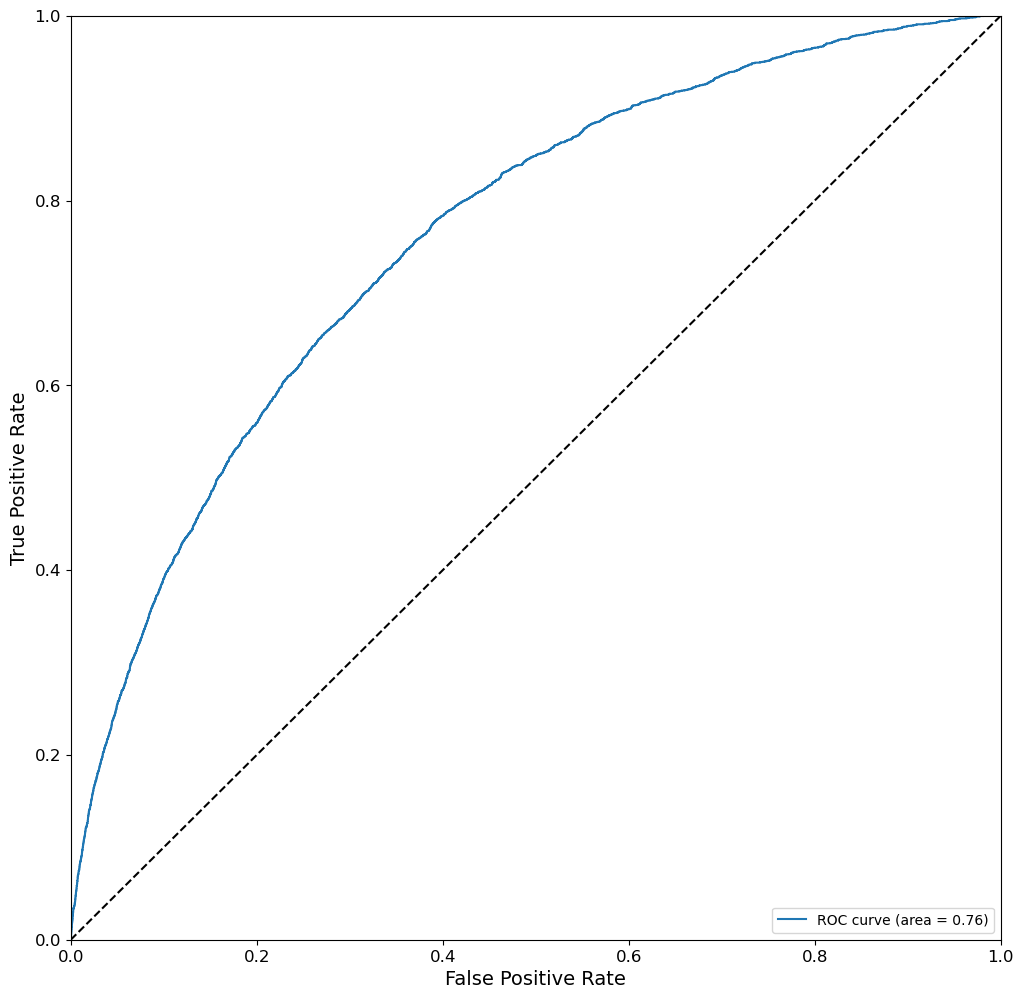

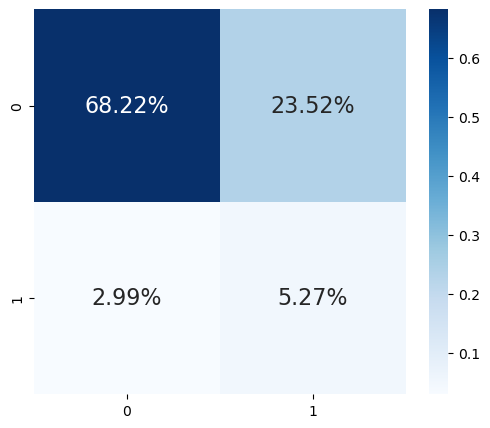

Accuracy_train:  0.7421		Accuracy_test:   0.7349
Precision_test:  0.1830		Recall_test:     0.6376
ROC-AUC_test:    0.7613		F1_test:         0.2844		MCC_test: 0.2318


In [29]:
class_mdls = {}
class_mdls['xgb_5_all'] = evaluate_class_mdl(fitted_mdl, X_train_enc, X_test_enc, y_train, y_test, plot_conf_matrix=True, ret_eval_dict=True)

In [31]:
rand = 3
for depth in range(4, 10):
    mdlname = 'xgb_'+str(depth)+'_all'
    stime = timeit.default_timer()
    class_mdl = XGBClassifier(max_depth=depth, n_estimators=200, objective='binary:logistic', tree_method='gpu_hist',  scale_pos_weight=10, learning_rate=0.1, min_child_weight=3, predictor='gpu_predictor', seed=rand)
    fitted_mdl = class_mdl.fit(X_train_enc, y_train)
    etime = timeit.default_timer()
    class_mdls[mdlname] = evaluate_class_mdl(fitted_mdl, X_train_enc, X_test_enc, y_train, y_test,\
                                            plot_roc=False, show_summary=False, ret_eval_dict=True)
    class_mdls[mdlname]['depth'] = depth
    class_mdls[mdlname]['fs'] = 'all'
    class_mdls[mdlname]['total_feat'] = class_mdls[mdlname]['fitted'].feature_importances_.shape[0]
    class_mdls[mdlname]['num_feat'] = sum(class_mdls[mdlname]['fitted'].feature_importances_ > 0)
    # Calculate percentage differences
    class_mdls[mdlname]['precision_diff'] = 100 - (class_mdls[mdlname]['precision_test']/class_mdls[mdlname]['precision_train'] * 100)
    class_mdls[mdlname]['precision_diff'] = class_mdls[mdlname]['precision_diff'].round(2)
    class_mdls[mdlname]['recall_diff'] = 100 - (class_mdls[mdlname]['recall_test']/class_mdls[mdlname]['recall_train'] * 100)
    class_mdls[mdlname]['recall_diff'] = class_mdls[mdlname]['recall_diff'].round(2)

In [32]:
class_metrics_df = pd.DataFrame.from_dict(class_mdls, 'index')\
                    [['depth', 'fs', 'precision_train', 'precision_test','precision_diff', 'recall_train', 'recall_test', 'recall_diff', 'roc-auc_test', 'num_feat']]

with pd.option_context('display.precision', 2):
    html = class_metrics_df.sort_values(by='depth', ascending=False).style.\
        background_gradient(cmap='plasma', low=0.3, high=1, subset=['precision_train', 'precision_test']).\
        background_gradient(cmap='gist_heat', low=0.3, high=3, subset=['precision_diff']).\
        background_gradient(cmap='viridis', low=1, high=0.3, subset=['recall_train', 'recall_test']).\
        background_gradient(cmap='gist_heat', low=0.3, high=3, subset=['recall_diff']).\
        background_gradient(cmap='cividis', low=0.3, high=1, subset=['roc-auc_test']).\
        format({"precision_train": "{:.5f}", "precision_test": "{:.5f}", "precision_diff": "{:.2f}%", 
             "recall_train": "{:.5f}", "recall_test": "{:.5f}", "recall_diff": "{:.2f}%", "roc-auc_test": "{:.5f}"})
html

,depth,fs,precision_train,precision_test,precision_diff,recall_train,recall_test,recall_diff,roc-auc_test,num_feat
xgb_9_all,9,all,0.44019,0.21930,50.18%,0.94786,0.43790,53.80%,0.74095,110
xgb_8_all,8,all,0.34082,0.20702,39.26%,0.87990,0.51190,41.82%,0.74949,110
xgb_7_all,7,all,0.27556,0.19481,29.31%,0.80840,0.56413,30.22%,0.75329,108
xgb_6_all,6,all,0.23392,0.19179,18.01%,0.74402,0.60592,18.56%,0.75843,108
xgb_5_all,5,all,0.20833,0.18787,9.82%,0.70469,0.63349,10.10%,0.76213,105
xgb_4_all,4,all,0.19331,0.18436,4.63%,0.67682,0.64510,4.69%,0.76342,99


## Filter-based Feature Selection Methods

### Quasi-Constant Features with Value-Counts

Filter-based methods serve as a practical strategy in feature selection for a dataset. These methods, operating independently of machine learning algorithms, base their functionality solely on the inherent properties of variables. Among these features, the focus here is on 'quasi-constant features', where the same value is prevalent in a significant proportion of rows. Detecting these quasi-constant features is crucial for tasks like credit scoring as they often contribute minimally to model performance due to their low variance.

To illustrate this, the process involves calculating the percentage of each value in a feature. If the highest percentage exceeds a predetermined threshold, the feature is identified as quasi-constant. The upcoming Python code demonstrates this with a 99.9% threshold. This means if the most common value in a feature is present in 99.9% or more of the rows, that feature is classified as 'quasi-constant'.

In [33]:
thresh = 0.999
quasi_const_cols = []
num_rows = X_train.shape[0]
for col in X_train.columns:
    top_val = (X_train[col].value_counts() /\
               num_rows).sort_values(ascending=False).values[0]
    
    if top_val >= thresh:
        quasi_const_cols.append(col)
print(quasi_const_cols)

['FLAG_CONT_MOBILE']


This output signifies that FLAG_CONT_MOBILE is a quasi-constant feature in the training dataset, as the majority of its rows (99.9% or more) contain the same value. For tasks like credit scoring, this information can help streamline the feature selection process for the machine learning model, as quasi-constant features due to their lack of variability often have minimal influence on the model's predictive capability. Thus, this will be removed from the training data.

In [34]:
X_train_orig = X_train_enc.copy(deep=True)
X_test_orig = X_test_enc.copy(deep=True)
drop_cols = quasi_const_cols
X_train_enc.drop(labels=drop_cols, axis=1, inplace=True)
X_test_enc.drop(labels=drop_cols, axis=1, inplace=True)

In [35]:
X_train_enc.shape

(236320, 116)

## Ranking filter-based methods via Mutual Information

The next stage in the feature selection process is utilizing ranking filter-based methods, specifically the Mutual Information selection method (MIC). This technique helps to determine the dependency between two variables; in this case, each feature and the target variable. It provides a ranking of the features based on the information they share with the target variable, which is invaluable for tasks such as credit scoring.

In the following Python code, the SelectKBest function from sklearn.feature_selection is utilized, alongside mutual_info_classif, to select the top 107 features that share the highest mutual information with the target variable.

In [36]:
mic_selection = SelectKBest(mutual_info_classif, k=107).fit(X_train_enc, y_train)
mic_cols = X_train_enc.columns[mic_selection.get_support()].tolist()
print(len(mic_cols))

107


This list of mic_cols now contains 107 features that share the highest mutual information with the target variable and can be used in subsequent analysis or model training for credit scoring.

## Embedded Feature Selection Methods

Advancing in the feature selection process, embedded methods are leveraged. These techniques - including LASSO LARS, LASSO LARS IC, and Logistic Regression with an L2 norm penalty - perform feature selection during the model training phase. This approach fosters an integration between the selection of features and the model's construction.

### LASSO LARS 

As the first step, a LASSO LARS CV model is applied. This model, once fit to the encoded training dataset, selects features based on their coefficients. The selected features are then outputted.

In [37]:
# Define the LassoLarsCV model with adjusted parameters
llars_selection = SelectFromModel(LassoLarsCV(n_jobs=-1, max_iter=1000, eps=0.001))

# Fit the model
llars_selection.fit(X_train_enc, y_train)

# Get the selected features
llars_cols = X_train_enc.columns[llars_selection.get_support()].tolist()

# Print the number of selected features and their names
print(len(llars_cols))
print(llars_cols)


77
['CONTRACT_TYPE_Cash loans', 'GENDER_F', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'INCOME_TYPE_Working', 'INCOME_TYPE_Pensioner', 'INCOME_TYPE_State servant', 'EDUCATION_TYPE_Secondary Education', 'EDUCATION_TYPE_Higher Education', 'FAMILY_STATUS_Married', 'FAMILY_STATUS_Single', 'FAMILY_STATUS_Widow', 'AGE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_SATURDAY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'LOG_A

c:\Users\ramdh\anaconda3\envs\homecredit4_env\Lib\site-packages\sklearn\linear_model\_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 113 iterations, alpha=5.052e-05, previous alpha=4.843e-05, with an active set of 88 regressors.
  warnings.warn(


On execution, it becomes evident that 70 features have been selected using the LASSO LARS CV methodology. The names of these features are captured in the llars_cols list.

### LASSO LARS IC

The next step in feature selection employs a LASSO LARS IC model. The 'IC' in LASSO LARS IC stands for 'Information Criterion'. This method uses criteria like the Akaike Information Criterion (AIC) to find the best model by trading off the model likelihood and the number of parameters. This technique ensures that the model is not too complex to overfit the data nor too simple to underfit the data. Following the same procedure as before, this model is fit to the encoded training dataset, with features selected based on the model's coefficients.

In [38]:
llarsic_selection = SelectFromModel(LassoLarsIC(criterion='aic', max_iter=1000, eps=0.001))
llarsic_selection.fit(X_train_enc, y_train)
llarsic_cols = X_train_enc.columns[llarsic_selection.get_support()].tolist()
print(len(llarsic_cols))
print(llarsic_cols)

c:\Users\ramdh\anaconda3\envs\homecredit4_env\Lib\site-packages\sklearn\linear_model\_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 113 iterations, alpha=5.052e-05, previous alpha=4.843e-05, with an active set of 88 regressors.
  warnings.warn(


77
['CONTRACT_TYPE_Cash loans', 'GENDER_F', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'INCOME_TYPE_Working', 'INCOME_TYPE_Pensioner', 'INCOME_TYPE_State servant', 'EDUCATION_TYPE_Secondary Education', 'EDUCATION_TYPE_Higher Education', 'FAMILY_STATUS_Married', 'FAMILY_STATUS_Single', 'FAMILY_STATUS_Widow', 'AGE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_SATURDAY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'LOG_A

After execution, it's discovered that the LASSO LARS IC methodology has led to the selection of 88 features. The names of these features are stored in the llarsic_cols list.

### Logistic Regression

Lastly, a Logistic Regression model with an L2 norm penalty is used for feature selection. The L2 norm penalty is chosen because it discourages large coefficients by squaring the values, which helps prevent overfitting and maintains model simplicity. This model is fit to the encoded training dataset, and feature selection is determined by the model's coefficients.

In [39]:
log_selection = SelectFromModel(LogisticRegression(C=0.0001, solver='newton-cholesky',\
                                    penalty='l2', n_jobs=-1, max_iter=500, random_state=3))
log_selection.fit(X_train_enc, y_train)
log_cols = X_train_enc.columns[log_selection.get_support()].tolist()
print(len(log_cols))
print(log_cols)

40
['CONTRACT_TYPE_Cash loans', 'CONTRACT_TYPE_Revolving loans', 'GENDER_M', 'GENDER_F', 'FLAG_OWN_CAR', 'INCOME_TYPE_Working', 'INCOME_TYPE_Pensioner', 'INCOME_TYPE_State servant', 'EDUCATION_TYPE_Secondary Education', 'EDUCATION_TYPE_Higher Education', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'HAS_FLAGGED_DOCUMENT', 'CREDIT_TO_INCOME_RATIO', 'PREV_HOUR_APPR_PROCESS_START_MEAN', 'PREV_SK_ID_PREV_NUNIQUE', 'PREV_NAME_CONTRACT_TYPE_MODE_Consumer loans', 'PREV_NAME_CONTRACT_TYPE_MODE_Cash loans', 'PREV_NAME_CONTRACT_TYPE_NUNIQUE', 'PREV_NAME_TYPE_SUITE_NUNIQUE', 'PREV_NAME_PORTFOLIO_MODE_POS', 'PREV_NAME_PORTFOLIO_MODE_Cards', 'PREV_NAME_PORTFOLIO_NUNIQUE', 'PREV_PRODUCT_COMBINATION_NUNIQUE', 'PREV_NAME_YIELD_GROUP_MODE_high', 'PREV_NAME_

Executing this process reveals that the Logistic Regression model with an L2 penalty has led to the selection of 41 features. These features are stored in the log_cols list.

## Evaluate Feature Selection Methods

The next step is to evaluate the performance of the selected features. This is accomplished by training an XGBoost model with different maximum depths (from 4 to 9) and comparing the results across different feature selection methods implemented earlier, including the scenario where all features are used.

The Python code that follows conducts this process by setting up and fitting an XGBoost classifier for each combination of maximum depth and feature selection method. Performance measures such as precision and recall for the train and test datasets are calculated. Differences in precision and recall between the training and test sets are also computed to provide insights into the model's performance.

In [ ]:
from sklearn.model_selection import cross_val_score

fsnames = ['e-llarsic', 'e-logl2', 'f-mic']
fscols = [llarsic_cols, log_cols, mic_cols]

max_depth_values = range(4, 10)  # max_depth from 8 to 10

for max_depth in max_depth_values:
    for i, fsname in enumerate(fsnames):
        cols = fscols[i]
        mdlname = 'xgb_'+str(max_depth)+'_'+fsname
        stime = timeit.default_timer()
        class_mdl =  XGBClassifier(max_depth=max_depth, n_estimators=200, objective='binary:logistic', tree_method='gpu_hist',  scale_pos_weight=10, learning_rate=0.1, min_child_weight=3, predictor='gpu_predictor', seed=rand)
        
        # Perform cross-validation and compute mean score
        cv_scores = cross_val_score(class_mdl, X_train_enc[cols], y_train, cv=3, scoring='roc_auc')
        cv_score_mean = np.mean(cv_scores)

        etime = timeit.default_timer()
        class_mdls[mdlname] = {'cv_score_mean': cv_score_mean, 'depth': max_depth, 'fs': fsname}


In [40]:
fsnames = ['e-llarsic', 'e-logl2', 'f-mic']
fscols = [llarsic_cols, log_cols, mic_cols]

max_depth_values = range(4, 10)  # max_depth from 8 to 10

for max_depth in max_depth_values:
    for i, fsname in enumerate(fsnames):
        cols = fscols[i]
        mdlname = 'xgb_'+str(max_depth)+'_'+fsname
        stime = timeit.default_timer()
        class_mdl =  XGBClassifier(max_depth=max_depth, n_estimators=200, objective='binary:logistic', tree_method='gpu_hist',  scale_pos_weight=10, learning_rate=0.1, min_child_weight=3, predictor='gpu_predictor', seed=rand)
        fitted_mdl = class_mdl.fit(X_train_enc[cols], y_train)
        etime = timeit.default_timer()
        class_mdls[mdlname] = evaluate_class_mdl(fitted_mdl, X_train_enc[cols], X_test_enc[cols], y_train, y_test,\
                                                plot_roc=False, show_summary=False, ret_eval_dict=True)
        class_mdls[mdlname]['depth'] = max_depth
        class_mdls[mdlname]['fs'] = fsname
        class_mdls[mdlname]['total_feat'] = class_mdls[mdlname]['fitted'].feature_importances_.shape[0]
        class_mdls[mdlname]['num_feat'] = sum(class_mdls[mdlname]['fitted'].feature_importances_ > 0)
        
        # Calculate percentage differences
        class_mdls[mdlname]['precision_diff'] = 100 - (class_mdls[mdlname]['precision_test']/class_mdls[mdlname]['precision_train'] * 100)
        class_mdls[mdlname]['precision_diff'] = class_mdls[mdlname]['precision_diff'].round(2)
        class_mdls[mdlname]['recall_diff'] = 100 - (class_mdls[mdlname]['recall_test']/class_mdls[mdlname]['recall_train'] * 100)
        class_mdls[mdlname]['recall_diff'] = class_mdls[mdlname]['recall_diff'].round(2)

class_metrics_df = pd.DataFrame.from_dict(class_mdls, 'index')\
                    [['depth', 'fs', 'precision_train', 'precision_test','precision_diff', 'recall_train', 'recall_test', 'recall_diff', 'roc-auc_test', 'num_feat']]

with pd.option_context('display.precision', 2):
    html = class_metrics_df.sort_values(by='roc-auc_test', ascending=False).style.\
        background_gradient(cmap='plasma', low=0.1, high=0.8, subset=['precision_train', 'precision_test']).\
        background_gradient(cmap='gist_heat', low=0.5, high=3, subset=['precision_diff']).\
        background_gradient(cmap='viridis', low=1, high=0.3, subset=['recall_train', 'recall_test']).\
        background_gradient(cmap='gist_heat', low=0.5, high=3, subset=['recall_diff']).\
        background_gradient(cmap='cividis', low=0.3, high=1, subset=['roc-auc_test']).\
            format({"precision_train": "{:.5f}", "precision_test": "{:.5f}", "precision_diff": "{:.2f}%", 
             "recall_train": "{:.5f}", "recall_test": "{:.5f}", "recall_diff": "{:.2f}%", "roc-auc_test": "{:.5f}"})

    
html

,depth,fs,precision_train,precision_test,precision_diff,recall_train,recall_test,recall_diff,roc-auc_test,num_feat
xgb_4_all,4,all,0.19331,0.18436,4.63%,0.67682,0.64510,4.69%,0.76342,99
xgb_4_f-mic,4,f-mic,0.19312,0.18410,4.67%,0.67698,0.64452,4.80%,0.76313,92
xgb_5_f-mic,5,f-mic,0.20873,0.18738,10.23%,0.70469,0.62972,10.64%,0.76241,98
xgb_5_all,5,all,0.20833,0.18787,9.82%,0.70469,0.63349,10.10%,0.76213,105
xgb_6_f-mic,6,f-mic,0.23429,0.19232,17.91%,0.74658,0.60766,18.61%,0.75894,98
xgb_6_all,6,all,0.23392,0.19179,18.01%,0.74402,0.60592,18.56%,0.75843,108
xgb_4_e-llarsic,4,e-llarsic,0.18671,0.17802,4.66%,0.67160,0.63929,4.81%,0.75525,74
xgb_5_e-llarsic,5,e-llarsic,0.19873,0.18017,9.34%,0.69367,0.62914,9.30%,0.75493,75
xgb_7_f-mic,7,f-mic,0.27660,0.19734,28.66%,0.80702,0.56355,30.17%,0.75377,99
xgb_7_all,7,all,0.27556,0.19481,29.31%,0.80840,0.56413,30.22%,0.75329,108


Several key insights can be drawn from the table to aid in selecting the optimal model:

- As the depth of the model increases, there is an apparent improvement in the precision and recall on the training data, indicating the model's enhanced accuracy in predicting loan default. However, these improvements do not translate to the test data metrics, suggesting the models may be overfitting. Overfitting is a scenario where the model performs exceptionally well on the training data but struggles to generalize to unseen, test data.

- Different feature selection methods lead to varying numbers of features being selected. For instance, the 'e-logl2' method (Logistic Regression with L2 norm penalty) consistently results in fewer features. However, having fewer features does not necessarily correspond to better performance on the test data.

- Models with depths of 4 and 5, which have been trained using the 'f-mic' method (Mutual Information selection method) or with all features, demonstrate relatively strong performance. They achieve ROC-AUC scores above 0.76 and display a smaller gap in precision and recall between the training and test datasets, suggesting better generalizability compared to models with larger depths.

In summary, in the task of predicting loan defaults, it's critical to maintain a balance between model complexity and performance. Even though models with higher training performance might be appealing, the capacity to generalize to unseen data is equally, if not more, important. As such, the models with depths of 4 and 5 trained with either 'f-mic' selected features or all features emerge as strong candidates, as they show good performance and signs of effective generalization. However, the final model choice should align with the specific business objectives and consider the potential impact and cost of incorrect predictions in the context of loan default prediction.

In [51]:
top_cols = list(set(mic_cols).union(set(llarsic_cols)))
len(top_cols)

111

## Advanced Feature Selection Methods

The next step in the feature selection process involves a combination of earlier methods to extract the most predictive features for loan default prediction. This includes the application of hybrid methods and Principal Component Analysis (PCA).

### Recursive Feature Elimination

The first hybrid method implemented is Recursive Feature Elimination (RFE) with Linear Discriminant Analysis (LDA). RFE is particularly useful in our context of imbalanced binary classification, as it helps pinpoint the most informative features by recursively removing the weakest ones until the specified number of features is left. After applying RFE with LDA, 112 features were found to be most significant, which are stored in rfe_lda_cols.

In [52]:
rfe_lda = RFECV(LinearDiscriminantAnalysis(n_components=min(y_train.nunique() - 1, X_train_enc.shape[1])), step=2,\
                cv=3, scoring='f1', verbose=2, n_jobs=-1)
rfe_lda.fit(X_train_enc[top_cols], y_train) 
rfe_lda_cols = np.array(X_train_enc[top_cols].columns)[rfe_lda.support_].tolist()
len(rfe_lda_cols)

Fitting estimator with 111 features.
Fitting estimator with 109 features.


107

Next, RFE is used again, but this time with XGBoost as the model. XGBoost, known for its high performance, provides the 'scale_pos_weight' parameter that is especially beneficial for imbalanced tasks like ours, as it assigns higher importance to the minority class. The 'max_depth' parameter is set to 4 to prevent the model from becoming overly complex and overfitting the training data. After applying RFE with XGBoost, 75 most impactful features were selected, which are stored in rfe_xgb_cols.

In [53]:
xgb_params1 = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'max_depth':4,
    'n_estimators': 200,
    'min_child_weight': 3,
    'scale_pos_weight': 10, 
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'eval_metric': 'auc',
    'seed':3
}

rfe_xgb = RFECV(XGBClassifier(**xgb_params1),\
               step=1, cv=3, scoring='f1',\
               verbose=2, n_jobs=-1)
rfe_xgb.fit(X_train_enc[top_cols],y_train) 
rfe_xgb_cols = np.array(top_cols)[rfe_xgb.support_].tolist()

Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimato

In [54]:
len(rfe_xgb_cols)

64

In [61]:
top_cols2 = list(set(rfe_lda_cols).union(set(rfe_xgb_cols)))
len(top_cols2)

110

## PCA

Lastly, PCA is utilized for feature selection. PCA helps to simplify the model by reducing the dimensionality of the data without losing important class separation information, making it ideal for our task of imbalanced binary classification. Upon application, the top 100 Principal Components (90% of the variance of top_cols), explaining the most variance, were selected and are stored in pca_cols.

In [64]:
pca = PCA(n_components=99)
fitted_pca = pca.fit(X_train_enc[top_cols2])

pca_evrs = pd.DataFrame({'col':X_train_enc[top_cols].columns[:len(fitted_pca.components_)], 'evr':fitted_pca.explained_variance_ratio_}).\
                        sort_values(by='evr',ascending=False)

pca_cols = pca_evrs.col.tolist()

In [63]:
90/100*110

99.0

In [58]:
len(pca_cols)

64

## Evaluating Advanced Feature Selection Methods

Building upon the previous steps, the next step involves evaluating performance using similar methods, with the selected features used for a variety of machine learning algorithms. Specifically, the models are trained on the previously obtained features rfe_lda_cols, rfe_xgb_cols, and pca_cols, across different tree depths (4 to 9), for the XGBoost classifier.

In [65]:
xgb_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'n_estimators': 200,
    'min_child_weight': 3,
    'scale_pos_weight': 10, 
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'eval_metric': 'auc',
    'seed':rand
}

max_depth_values = range(4, 10)  # max_depth from 8 to 10
# fsnames = ['h-rfe-lda','h-rfe-xgb', 'a-pca']
# fscols = [rfe_lda_cols, rfe_xgb_cols, pca_cols]
fsnames = ['a-pca']
fscols = [pca_cols]
for max_depth in max_depth_values:
    for i, fsname in enumerate(fsnames):
        cols = fscols[i]
        mdlname = 'xgb_'+str(max_depth)+'_'+fsname
        stime = timeit.default_timer()
        class_mdl =  XGBClassifier(max_depth=max_depth, n_estimators=200, objective='binary:logistic', tree_method='gpu_hist',  scale_pos_weight=10, learning_rate=0.1, min_child_weight=3, predictor='gpu_predictor', seed=rand)
        fitted_mdl = class_mdl.fit(X_train_enc[cols], y_train)
        etime = timeit.default_timer()
        class_mdls[mdlname] = evaluate_class_mdl(fitted_mdl, X_train_enc[cols], X_test_enc[cols], y_train, y_test,\
                                                plot_roc=False, show_summary=False, ret_eval_dict=True)
        class_mdls[mdlname]['depth'] = max_depth
        class_mdls[mdlname]['fs'] = fsname
        class_mdls[mdlname]['total_feat'] = class_mdls[mdlname]['fitted'].feature_importances_.shape[0]
        class_mdls[mdlname]['num_feat'] = sum(class_mdls[mdlname]['fitted'].feature_importances_ > 0)
        
        # Calculate percentage differences
        class_mdls[mdlname]['precision_diff'] = 100 - (class_mdls[mdlname]['precision_test']/class_mdls[mdlname]['precision_train'] * 100)
        class_mdls[mdlname]['precision_diff'] = class_mdls[mdlname]['precision_diff'].round(2)
        class_mdls[mdlname]['recall_diff'] = 100 - (class_mdls[mdlname]['recall_test']/class_mdls[mdlname]['recall_train'] * 100)
        class_mdls[mdlname]['recall_diff'] = class_mdls[mdlname]['recall_diff'].round(2)

In [60]:
class_metrics_df = pd.DataFrame.from_dict(class_mdls, 'index')\
                    [['depth', 'fs', 'precision_train', 'precision_test','precision_diff', 'recall_train', 'recall_test', 'recall_diff', 'roc-auc_test', 'num_feat']]

with pd.option_context('display.precision', 2):
    html = class_metrics_df.sort_values(by='roc-auc_test', ascending=False).style.\
        background_gradient(cmap='plasma', low=0.1, high=0.8, subset=['precision_train', 'precision_test']).\
        background_gradient(cmap='gist_heat', low=0.5, high=3, subset=['precision_diff']).\
        background_gradient(cmap='viridis', low=0.3, high=0.8, subset=['recall_train', 'recall_test']).\
        background_gradient(cmap='gist_heat', low=0.5, high=3, subset=['recall_diff']).\
        background_gradient(cmap='cividis', low=0.3, high=2, subset=['roc-auc_test']).\
            format({"precision_train": "{:.5f}", "precision_test": "{:.5f}", "precision_diff": "{:.2f}%", 
             "recall_train": "{:.5f}", "recall_test": "{:.5f}", "recall_diff": "{:.2f}%", "roc-auc_test": "{:.5f}"})

    
html

,depth,fs,precision_train,precision_test,precision_diff,recall_train,recall_test,recall_diff,roc-auc_test,num_feat
xgb_4_h-rfe-lda,4,h-rfe-lda,0.19307,0.18215,5.66%,0.67785,0.64016,5.56%,0.76356,96
xgb_4_all,4,all,0.19331,0.18436,4.63%,0.67682,0.64510,4.69%,0.76342,99
xgb_4_h-rfe-xgb,4,h-rfe-xgb,0.19313,0.18383,4.81%,0.67672,0.64393,4.84%,0.76327,64
xgb_4_f-mic,4,f-mic,0.19312,0.18410,4.67%,0.67698,0.64452,4.80%,0.76313,92
xgb_5_f-mic,5,f-mic,0.20873,0.18738,10.23%,0.70469,0.62972,10.64%,0.76241,98
xgb_5_all,5,all,0.20833,0.18787,9.82%,0.70469,0.63349,10.10%,0.76213,105
xgb_5_h-rfe-xgb,5,h-rfe-xgb,0.20753,0.18739,9.70%,0.70238,0.63117,10.14%,0.76204,64
xgb_5_h-rfe-lda,5,h-rfe-lda,0.20858,0.18640,10.63%,0.70525,0.62594,11.25%,0.76103,100
xgb_6_f-mic,6,f-mic,0.23429,0.19232,17.91%,0.74658,0.60766,18.61%,0.75894,98
xgb_6_all,6,all,0.23392,0.19179,18.01%,0.74402,0.60592,18.56%,0.75843,108


The results of these models provide several key insights:

- Looking at the ROC-AUC scores, which is a primary evaluation metric for the classifier performance in this binary classification task, XGBoost classifiers trained on the features obtained using f-mic, h-rfe-xgb, h-rfe-lda, and all perform comparably with scores around 0.76, suggesting these feature sets to be effective in the prediction task.

- Models trained on features selected by h-rfe-xgb consistently perform slightly better than those trained on h-rfe-lda, suggesting that XGBoost might be more suitable for this task compared to LDA.

- A depth of 5 seems to provide a good trade-off between complexity and performance for models trained on f-mic, h-rfe-xgb, and h-rfe-lda. Beyond this, as depth increases, overfitting becomes apparent with the precision and recall differences between the training and testing sets becoming larger.

- The models trained on features obtained using PCA (a-pca) perform worse than the others, with ROC-AUC scores around 0.70. This indicates that some important information might have been lost during dimensionality reduction with PCA.

To summarize:

- Feature sets derived from Mutual Information (MIC) selection, Recursive Feature Elimination with XGBoost, and Recursive Feature Elimination with LDA, offer a good basis for predicting loan default in the XGBoost classifier.
- PCA, in this case, might have oversimplified the data, leading to a loss in predictive power.
- Models trained on features selected by Recursive Feature Elimination with XGBoost perform slightly better than those selected by LDA.
- A tree depth of 5 provides a good balance between model complexity and performance for this particular task. As depth increases, a trend towards overfitting is observed.
- It is also observed that in this context, using all features does not necessarily provide better results. Hence, it underlines the importance of an effective feature selection process.

Given these findings, it's clear that feature selection plays a critical role in building an effective model. A good balance between model complexity and performance is crucial to avoid overfitting while still capturing essential patterns in the data. In the next steps, these insights will be invaluable in guiding further model optimization and refinement.

In [98]:
def create_class_metrics_df(class_mdls_hyp):
    class_metrics_df = pd.DataFrame.from_dict(class_mdls_hyp, 'index')\
                        [['fs', 'precision_train', 'precision_test','precision_diff', 'recall_train', 'recall_test', 'recall_diff', 'roc-auc_test', 'num_feat']]

    html = class_metrics_df.sort_values(by='roc-auc_test', ascending=False).style.\
        background_gradient(cmap='plasma', low=0.1, high=0.8, subset=['precision_train', 'precision_test']).\
        background_gradient(cmap='gist_heat', low=0.5, high=3, subset=['precision_diff']).\
        background_gradient(cmap='viridis', low=0.3, high=0.8, subset=['recall_train', 'recall_test']).\
        background_gradient(cmap='gist_heat', low=0.5, high=3, subset=['recall_diff']).\
        background_gradient(cmap='cividis', low=0.3, high=2, subset=['roc-auc_test']).\
            format({"precision_train": "{:.5f}", "precision_test": "{:.5f}", "precision_diff": "{:.2f}%", 
             "recall_train": "{:.5f}", "recall_test": "{:.5f}", "recall_diff": "{:.2f}%", "roc-auc_test": "{:.5f}"})

    return html


In [82]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold


# Define the parameter space
space = {
    'max_depth': hp.choice('max_depth', range(3,6)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'n_estimators': hp.choice('n_estimators', range(100, 400, 5)),
}

def objective(params):
    """Objective function for Hyperopt."""
    params = {
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'tree_method': 'gpu_hist',  # Use GPU acceleration
        'scale_pos_weight': 10,
    }
    
    clf = XGBClassifier(**params)
    score = cross_val_score(clf, X_train_enc[top_cols2], y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=3)).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Run the optimization
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=150,
            trials=Trials())

print("Best: ", best)


100%|██████████| 150/150 [13:15<00:00,  5.31s/trial, best loss: -0.7564124220387077]
Best:  {'learning_rate': 0.09610271357432033, 'max_depth': 0, 'n_estimators': 48}


In [77]:
print("Best parameters: ", best)
print('max_depth:', list(range(3,6))[best['max_depth']])
print('learning_rate:', best['learning_rate'])
print('n_estimators:', list(range(20, 400, 5))[best['n_estimators']])
# print('min_child_weight:', list(range(1,5))[best['min_child_weight']])

Best parameters: 
max_depth: 3
learning_rate: 0.11843016900051939
n_estimators: 330


In [97]:
xgb_params_best = {
    'objective': 'binary:logistic',
    'learning_rate': 0.11843016900051939,
    'max_delta_step': 2,
    'n_estimators': 330,
    'min_child_weight': 4,
    'max_depth':3,
    'scale_pos_weight': 10, 
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'eval_metric': 'auc',
    'seed':rand
}

fsnames = ['h-rfe-lda','h-rfe-xgb', 'a-pca', 'f-mic']
fscols = [rfe_lda_cols, rfe_xgb_cols, pca_cols, mic_cols]
class_mdls_hyp = {}
for i, fsname in enumerate(fsnames):
        cols = fscols[i]
        mdlname = 'xgb_'+'hyp'+'_'+fsname
        stime = timeit.default_timer()
        class_mdl =  XGBClassifier(**xgb_params_best)
        fitted_mdl = class_mdl.fit(X_train_enc[cols], y_train)
        etime = timeit.default_timer()
        class_mdls_hyp[mdlname] = evaluate_class_mdl(fitted_mdl, X_train_enc[cols], X_test_enc[cols], y_train, y_test,\
                                                plot_roc=False, show_summary=False, ret_eval_dict=True)
        class_mdls_hyp[mdlname]['fs'] = fsname
        class_mdls_hyp[mdlname]['total_feat'] = class_mdls_hyp[mdlname]['fitted'].feature_importances_.shape[0]
        class_mdls_hyp[mdlname]['num_feat'] = sum(class_mdls_hyp[mdlname]['fitted'].feature_importances_ > 0)
        
        # Calculate percentage differences
        class_mdls_hyp[mdlname]['precision_diff'] = 100 - (class_mdls_hyp[mdlname]['precision_test']/class_mdls_hyp[mdlname]['precision_train'] * 100)
        class_mdls_hyp[mdlname]['precision_diff'] = class_mdls_hyp[mdlname]['precision_diff'].round(2)
        class_mdls_hyp[mdlname]['recall_diff'] = 100 - (class_mdls_hyp[mdlname]['recall_test']/class_mdls_hyp[mdlname]['recall_train'] * 100)
        class_mdls_hyp[mdlname]['recall_diff'] = class_mdls_hyp[mdlname]['recall_diff'].round(2)

In [99]:
html = create_class_metrics_df(class_mdls_hyp)
html


,fs,precision_train,precision_test,precision_diff,recall_train,recall_test,recall_diff,roc-auc_test,num_feat
xgb_hyp_h-rfe-xgb,h-rfe-xgb,0.19106,0.18323,4.10%,0.67175,0.64423,4.10%,0.76433,64
xgb_hyp_f-mic,f-mic,0.19123,0.18503,3.24%,0.67237,0.64771,3.67%,0.76421,92
xgb_hyp_h-rfe-lda,h-rfe-lda,0.19098,0.18483,3.22%,0.67283,0.64858,3.60%,0.76384,87
xgb_hyp_a-pca,a-pca,0.19113,0.18245,4.54%,0.67273,0.64248,4.50%,0.76332,88


Next, we proceed using different types of scalers and feature selection methods to preprocess the data before running an XGBoost classification model. The scalers used include StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, and Normalizer. Feature selection methods used include Mutual Information Coefficient (MIC), Recursive Feature Elimination (RFE) with XGBoost estimator, and Recursive Feature Elimination with Linear Discriminant Analysis (LDA) estimator.

The objective is to identify the combination of scaler and feature selection method that results in the best performing XGBoost model, as measured by precision, recall, and ROC-AUC score on a test dataset.

In [103]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer, Normalizer


scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'QuantileTrans': QuantileTransformer(),
    'PowerTrans': PowerTransformer(),
    'Normalizer': Normalizer()
}

cols_to_scale = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'AGE', 'DAYS_EMPLOYED',
                 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2',
                 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
                 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'LOG_AMT_INCOME_TOTAL',
                 'FLAG_DOCUMENT_COUNT', 'CREDIT_TO_INCOME_RATIO', 'ANNUITY_TO_INCOME_RATIO',
                 'PREV_AMT_ANNUITY_MEDIAN', 'PREV_AMT_ANNUITY_SUM', 'PREV_AMT_APPLICATION_MEDIAN',
                 'PREV_AMT_APPLICATION_SUM', 'PREV_AMT_CREDIT_MEDIAN', 'PREV_AMT_CREDIT_SUM',
                 'PREV_AMT_GOODS_PRICE_MEDIAN', 'PREV_AMT_GOODS_PRICE_SUM',
                 'PREV_HOUR_APPR_PROCESS_START_MEAN', 'PREV_DAYS_DECISION_MEDIAN',
                 'PREV_CNT_PAYMENT_MEDIAN', 'PREV_CNT_PAYMENT_SUM', 'PREV_SK_ID_PREV_NUNIQUE',
                 'PREV_SIMPLE_INTERESTS_MAX']


xgb_params_best = {
    'objective': 'binary:logistic',
    'learning_rate': 0.11843016900051939,
    'max_delta_step': 2,
    'n_estimators': 330,
    'min_child_weight': 4,
    'max_depth':3,
    'scale_pos_weight': 10, 
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'eval_metric': 'auc',
    'seed':rand
}

fsname = 'h-rfe-lda'
cols = rfe_lda_cols

for scaler_name, scaler in scalers.items():
    # Select the columns to be scaled
    cols_to_scale = [col for col in cols if col in cols_to_scale]

    # Copy the dataframe
    X_train_enc_copy = X_train_enc.copy(deep=True)
    X_test_enc_copy = X_test_enc.copy(deep=True)

    # Scale the selected columns
    X_train_enc_copy[cols_to_scale] = scaler.fit_transform(X_train_enc_copy[cols_to_scale])
    X_test_enc_copy[cols_to_scale] = scaler.transform(X_test_enc_copy[cols_to_scale])

    mdlname = 'xgb_'+'hyp'+'_'+fsname+'_'+scaler_name  # Add the scaler name to the model name
    stime = timeit.default_timer()
    class_mdl =  XGBClassifier(**xgb_params_best)
    fitted_mdl = class_mdl.fit(X_train_enc_copy[cols], y_train)
    etime = timeit.default_timer()
    class_mdls_hyp[mdlname] = evaluate_class_mdl(fitted_mdl, X_train_enc_copy[cols], X_test_enc_copy[cols], y_train, y_test, plot_roc=False, show_summary=False, ret_eval_dict=True)
    class_mdls_hyp[mdlname]['fs'] = fsname
    class_mdls_hyp[mdlname]['scaler'] = scaler_name  # Store the name of the scaler used
    class_mdls_hyp[mdlname]['total_feat'] = class_mdls_hyp[mdlname]['fitted'].feature_importances_.shape[0]
    class_mdls_hyp[mdlname]['num_feat'] = sum(class_mdls_hyp[mdlname]['fitted'].feature_importances_ > 0)
    
    # Calculate percentage differences
    class_mdls_hyp[mdlname]['precision_diff'] = 100 - (class_mdls_hyp[mdlname]['precision_test']/class_mdls_hyp[mdlname]['precision_train'] * 100)
    class_mdls_hyp[mdlname]['precision_diff'] = class_mdls_hyp[mdlname]['precision_diff'].round(2)
    class_mdls_hyp[mdlname]['recall_diff'] = 100 - (class_mdls_hyp[mdlname]['recall_test']/class_mdls_hyp[mdlname]['recall_train'] * 100)

html = create_class_metrics_df(class_mdls_hyp)
html

,fs,precision_train,precision_test,precision_diff,recall_train,recall_test,recall_diff,roc-auc_test,num_feat
xgb_hyp_h-rfe-xgb_MinMaxScaler,h-rfe-xgb,0.19091,0.18444,3.39%,0.67119,0.64858,3.37%,0.76441,64
xgb_hyp_h-rfe-xgb_StandardScaler,h-rfe-xgb,0.19142,0.18376,4.00%,0.67227,0.64626,3.87%,0.76435,64
xgb_hyp_h-rfe-xgb,h-rfe-xgb,0.19106,0.18323,4.10%,0.67175,0.64423,4.10%,0.76433,64
xgb_hyp_h-rfe-xgb_RobustScaler,h-rfe-xgb,0.19098,0.18418,3.56%,0.67088,0.64713,3.54%,0.76431,64
xgb_hyp_f-mic_PowerTrans,f-mic,0.19090,0.18590,2.62%,0.67104,0.65061,3.04%,0.76428,93
xgb_hyp_f-mic,f-mic,0.19123,0.18503,3.24%,0.67237,0.64771,3.67%,0.76421,92
xgb_hyp_f-mic_QuantileTrans,f-mic,0.19069,0.18462,3.18%,0.67211,0.65090,3.16%,0.76414,96
xgb_hyp_f-mic_StandardScaler,f-mic,0.19131,0.18479,3.41%,0.67170,0.64858,3.44%,0.76396,89
xgb_hyp_h-rfe-lda_StandardScaler,h-rfe-lda,0.19135,0.18461,3.52%,0.67355,0.64945,3.58%,0.76396,92
xgb_hyp_f-mic_RobustScaler,f-mic,0.19134,0.18510,3.26%,0.67222,0.64974,3.34%,0.76384,92


The table is essentially a ranking of different combinations of feature scaling and feature selection approaches. Each row corresponds to a different combination and displays several key metrics for the corresponding model: precision, recall, ROC-AUC, and the number of features used. 

The top-performing model in terms of ROC-AUC on the test set is the one that used Recursive Feature Elimination (RFE) with an XGBoost estimator for feature selection and MinMaxScaler for scaling. It's indicated by 'xgb_hyp_h-rfe-xgb_MinMaxScaler'. This model achieved the highest ROC-AUC score of 0.76441 on the test set.

Key observations from the table include:

- The difference between precision and recall for training and testing sets for the top-performing model is small (around 3.39% for precision and 3.37% for recall). This indicates that the model generalizes well and is not overfitting.

- Models that used a Normalizer for scaling ('xgb_hyp_h-rfe-xgb_Normalizer', 'xgb_hyp_f-mic_Normalizer') performed poorly in terms of ROC-AUC scores. These models also showed the highest discrepancies in precision and recall between the training and testing sets, indicating potential overfitting.

- Interestingly, the number of features used by the models does not seem to directly correlate with their performance. The best-performing model used 64 features, but other models with comparable performance used significantly more features, up to 96 in some cases.

In conclusion, the results highlight the importance of the right combination of feature selection and scaling techniques. The highest-performing model employed Recursive Feature Elimination with an XGBoost estimator for feature selection and the MinMaxScaler for feature scaling. However, the number of features used in the model doesn't necessarily determine its performance. It seems that other factors such as feature selection method and scaling technique have more influence on the model's performance.


In [110]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

# Define the parameter space
space = {
    'max_depth': hp.choice('max_depth', range(3,8)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', range(20, 300, 5)),
    'gamma': hp.uniform('gamma', 0.0, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
    'subsample': hp.uniform('subsample', 0.8, 1),
    'min_child_weight': hp.choice('min_child_weight', range(1,5)),
    'scale_pos_weight': hp.choice('scale_pos_weight', range(6,13)),
    'max_delta_step': hp.choice('max_delta_step', range(1,10)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    
}

def objective(params):
    """Objective function for Hyperopt."""
    params = {
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'gamma': params['gamma'],
        'colsample_bytree': params['colsample_bytree'],
        'subsample': params['subsample'],
        'min_child_weight': params['min_child_weight'],
        'scale_pos_weight': params['scale_pos_weight'] + 6,  # Add 6 to the chosen index
        'max_delta_step': params['max_delta_step'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'tree_method': 'gpu_hist',  # Use GPU acceleration
    }
    
    clf = XGBClassifier(**params)
    score = cross_val_score(clf, X_train_enc[top_cols2], y_train, scoring='roc_auc', cv=StratifiedKFold(n_splits=2)).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)

best

100%|██████████| 200/200 [08:11<00:00,  2.46s/trial, best loss: -0.7554168487997756]


{'colsample_bytree': 0.6643146549674357,
 'gamma': 0.06982646539497872,
 'learning_rate': 0.09820171572475223,
 'max_delta_step': 0,
 'max_depth': 0,
 'min_child_weight': 1,
 'n_estimators': 51,
 'reg_alpha': 0.2875632064598965,
 'reg_lambda': 0.25145126949754415,
 'scale_pos_weight': 1,
 'subsample': 0.8747154557302282}

In [116]:
print("Best parameters: ")
print('max_depth:', list(range(3,8))[best['max_depth']])
print('learning_rate:', best['learning_rate'])
print('n_estimators:', list(range(20, 300, 5))[best['n_estimators']])
print('gamma:', best['gamma'])
print('colsample_bytree:', best['colsample_bytree'])
print('subsample:', best['subsample'])
print('min_child_weight:', list(range(1,5))[best['min_child_weight']])
print('scale_pos_weight:', list(range(6,13))[best['scale_pos_weight']])


Best parameters: 
max_depth: 3
learning_rate: 0.09820171572475223
n_estimators: 275
gamma: 0.06982646539497872
colsample_bytree: 0.6643146549674357
subsample: 0.8747154557302282
min_child_weight: 2
scale_pos_weight: 7


## CATBOOST

In this section, we start the analysis with the CatBoost classifier using its default parameters. The aim of this experiment is to observe and compare the results achieved with CatBoost to those previously obtained using XGBoost.

The experimental setup includes multiple feature selection methods - 'h-rfe-lda','h-rfe-xgb', 'a-pca', 'f-mic' and various pre-processing scalers. No parameter tuning has been performed yet for CatBoost. 

In [105]:
from catboost import CatBoostClassifier

class_mdls_hyp = {}

fsnames = ['h-rfe-lda','h-rfe-xgb', 'a-pca', 'f-mic']
fscols = [rfe_lda_cols, rfe_xgb_cols, pca_cols, mic_cols]

for scaler_name, scaler in scalers.items():
    for i, fsname in enumerate(fsnames):
        # Apply the scaler to your data
        cols = fscols[i]
        X_train_enc_scaled = scaler.fit_transform(X_train_enc[cols])
        X_test_enc_scaled = scaler.transform(X_test_enc[cols])

        mdlname = 'cat_'+'_'+fsname+'_'+scaler_name  # Add the scaler name to the model name
        stime = timeit.default_timer()
        class_mdl = CatBoostClassifier(random_seed=rand, verbose=False)
        fitted_mdl = class_mdl.fit(X_train_enc_scaled, y_train)
        etime = timeit.default_timer()
        class_mdls_hyp[mdlname] = evaluate_class_mdl(fitted_mdl, X_train_enc_scaled, X_test_enc_scaled, y_train, y_test,\
                                                        plot_roc=False, show_summary=False, ret_eval_dict=True)
        class_mdls_hyp[mdlname]['fs'] = fsname
        class_mdls_hyp[mdlname]['scaler'] = scaler_name  # Store the name of the scaler used
        class_mdls_hyp[mdlname]['total_feat'] = class_mdls_hyp[mdlname]['fitted'].feature_importances_.shape[0]
        class_mdls_hyp[mdlname]['num_feat'] = sum(class_mdls_hyp[mdlname]['fitted'].feature_importances_ > 0)
            
        # Calculate percentage differences
        class_mdls_hyp[mdlname]['precision_diff'] = 100 - (class_mdls_hyp[mdlname]['precision_test']/class_mdls_hyp[mdlname]['precision_train'] * 100)
        class_mdls_hyp[mdlname]['precision_diff'] = class_mdls_hyp[mdlname]['precision_diff'].round(2)
        class_mdls_hyp[mdlname]['recall_diff'] = 100 - (class_mdls_hyp[mdlname]['recall_test']/class_mdls_hyp[mdlname]['recall_train'] * 100)
        class_mdls_hyp[mdlname]['recall_diff'] = class_mdls_hyp[mdlname]['recall_diff'].round(2)

In [106]:
html = create_class_metrics_df(class_mdls_hyp)
html

,fs,precision_train,precision_test,precision_diff,recall_train,recall_test,recall_diff,roc-auc_test,num_feat
cat__h-rfe-lda_RobustScaler,h-rfe-lda,0.92512,0.47012,49.18%,0.09111,0.03424,62.42%,0.76211,106
cat__f-mic_RobustScaler,f-mic,0.93769,0.48430,48.35%,0.09403,0.03134,66.67%,0.76186,107
cat__f-mic_PowerTrans,f-mic,0.92481,0.46121,50.13%,0.09260,0.03105,66.47%,0.76185,106
cat__a-pca_QuantileTrans,a-pca,0.94240,0.45415,51.81%,0.09301,0.03018,67.55%,0.76166,98
cat__h-rfe-lda_QuantileTrans,h-rfe-lda,0.93603,0.48131,48.58%,0.09367,0.02989,68.09%,0.76150,106
cat__h-rfe-lda_StandardScaler,h-rfe-lda,0.93279,0.45946,50.74%,0.09383,0.02960,68.45%,0.76128,105
cat__h-rfe-lda_MinMaxScaler,h-rfe-lda,0.92992,0.47748,48.65%,0.09311,0.03076,66.96%,0.76123,107
cat__a-pca_RobustScaler,a-pca,0.93172,0.46637,49.95%,0.09086,0.03018,66.78%,0.76121,99
cat__f-mic_QuantileTrans,f-mic,0.93643,0.50420,46.16%,0.09506,0.03482,63.37%,0.76098,106
cat__h-rfe-lda_PowerTrans,h-rfe-lda,0.92843,0.47368,48.98%,0.09301,0.03134,66.30%,0.76087,107


Upon executing the code, the following interpretations can be made from the results:

- Looking at the `roc-auc_test` scores, it's clear that the models perform quite consistently across different feature selection methods and scalers, with scores close to 0.76.
- The best performing model configuration, as indicated by the highest ROC-AUC score on the test data, appears to be `cat__h-rfe-lda_RobustScaler`.
- There's a significant gap between the train and test precision scores for all models, suggesting potential overfitting to the training data.
- The `recall_train` and `recall_test` scores are relatively low across all models, indicating a less successful identification of the positive class.
- The `precision_diff` and `recall_diff` further show a substantial difference in precision and recall between the training and test sets, reinforcing the overfitting concern.
- The `num_feat` column shows the number of features used by the model. The `h-rfe-xgb` feature selection method uses the fewest features, suggesting a potentially more efficient and interpretable model, though it does not necessarily yield the highest ROC-AUC.

In summary, while CatBoost provides promising results using default settings, further adjustments may be required to address the observed overfitting, possibly through regularization or advanced feature selection methods.

In [109]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

# define objective function for optimization
def objective(params):
    params = {
        'learning_rate': params['learning_rate'],
        'depth': int(params['depth']),
        'l2_leaf_reg': int(params['l2_leaf_reg'])
    }
    
    clf = CatBoostClassifier(iterations=500,
                             learning_rate=params['learning_rate'],
                             depth=int(params['depth']),
                             l2_leaf_reg=params['l2_leaf_reg'],
                             eval_metric='AUC',
                             random_seed=rand,
                             verbose=False)
    
    clf.fit(X_train_enc[rfe_xgb_cols], y_train, eval_set=(X_test_enc[rfe_xgb_cols], y_test), use_best_model=True)
    
    preds = clf.predict_proba(X_test_enc[rfe_xgb_cols])[:, 1]
    auc = roc_auc_score(y_test, preds)
    
    return {'loss': -auc, 'status': STATUS_OK}

# define search space for parameters
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'depth': hp.quniform('depth', 2, 12, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
}

trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best: ", best)


100%|██████████| 100/100 [26:30<00:00, 15.91s/trial, best loss: -0.764836001965699]
Best:  {'depth': 5.0, 'l2_leaf_reg': 7.797926120491243, 'learning_rate': 0.09594645366823233}


In [ ]:
# Define CatBoost parameters
cat_params_best = {
    'learning_rate': 0.09594645366823233,
    'depth': 3,
    'l2_leaf_reg': 7.797926120491243,
    'loss_function': 'Logloss',
    'scale_pos_weight':10,
    'eval_metric': 'AUC',
    'task_type' : 'GPU',
    'logging_level': 'Silent',
    'bootstrap_type':'Bayesian',
    'random_seed': rand
}

class_mdls_hyp = {}

fsnames = ['h-rfe-lda','h-rfe-xgb', 'f-mic']
fscols = [rfe_lda_cols, rfe_xgb_cols, mic_cols]

for scaler_name, scaler in scalers.items():
    X_train_enc_scaled = X_train_enc.copy()
    X_test_enc_scaled = X_test_enc.copy()

    # Apply the scaler only to the columns in cols_to_scale
    X_train_enc_scaled[cols_to_scale] = scaler.fit_transform(X_train_enc[cols_to_scale])
    X_test_enc_scaled[cols_to_scale] = scaler.transform(X_test_enc[cols_to_scale])
    
    for i, fsname in enumerate(fsnames):
        # Apply the feature selection
        cols = fscols[i]
        
        mdlname = 'cat_'+'opt'+'_'+ fsname + '_' + scaler_name  # Add the scaler name to the model name
        stime = timeit.default_timer()
        class_mdl = CatBoostClassifier(**cat_params_best)
        fitted_mdl = class_mdl.fit(X_train_enc_scaled[cols], y_train)
        etime = timeit.default_timer()
        class_mdls_hyp[mdlname] = evaluate_class_mdl(fitted_mdl, X_train_enc_scaled[cols], X_test_enc_scaled[cols], y_train, y_test,\
                                                        plot_roc=False, show_summary=False, ret_eval_dict=True)
        class_mdls_hyp[mdlname]['fs'] = fsname
        class_mdls_hyp[mdlname]['scaler'] = scaler_name  # Store the name of the scaler used
        class_mdls_hyp[mdlname]['total_feat'] = class_mdls_hyp[mdlname]['fitted'].feature_importances_.shape[0]
        class_mdls_hyp[mdlname]['num_feat'] = sum(class_mdls_hyp[mdlname]['fitted'].feature_importances_ > 0)
            
        # Calculate percentage differences
        class_mdls_hyp[mdlname]['precision_diff'] = 100 - (class_mdls_hyp[mdlname]['precision_test']/class_mdls_hyp[mdlname]['precision_train'] * 100)
        class_mdls_hyp[mdlname]['precision_diff'] = class_mdls_hyp[mdlname]['precision_diff'].round(2)
        class_mdls_hyp[mdlname]['recall_diff'] = 100 - (class_mdls_hyp[mdlname]['recall_test']/class_mdls_hyp[mdlname]['recall_train'] * 100)
        class_mdls_hyp[mdlname]['recall_diff'] = class_mdls_hyp[mdlname]['recall_diff'].round(2)


In [122]:
html = create_class_metrics_df(class_mdls_hyp)
html

,fs,precision_train,precision_test,precision_diff,recall_train,recall_test,recall_diff,roc-auc_test,num_feat
cat_opt_h-rfe-lda_QuantileTrans,h-rfe-lda,0.19445,0.18563,4.54%,0.67380,0.64161,4.78%,0.76509,102
cat_opt_h-rfe-lda_MinMaxScaler,h-rfe-lda,0.19453,0.18696,3.89%,0.67262,0.64335,4.35%,0.76479,102
cat_opt_h-rfe-lda_PowerTrans,h-rfe-lda,0.19455,0.18604,4.38%,0.67319,0.64335,4.43%,0.76472,99
cat_opt_f-mic_PowerTrans,f-mic,0.19531,0.18644,4.54%,0.67411,0.64219,4.73%,0.76462,103
cat_opt_f-mic_RobustScaler,f-mic,0.19503,0.18525,5.01%,0.67298,0.63929,5.01%,0.76439,102
cat_opt_f-mic_MinMaxScaler,f-mic,0.19474,0.18613,4.42%,0.67375,0.64016,4.99%,0.76436,102
cat_opt_f-mic_StandardScaler,f-mic,0.19468,0.18619,4.36%,0.67309,0.64103,4.76%,0.76434,102
cat_opt_h-rfe-lda_RobustScaler,h-rfe-lda,0.19480,0.18631,4.36%,0.67396,0.64219,4.71%,0.76428,103
cat_opt_h-rfe-xgb_StandardScaler,h-rfe-xgb,0.19473,0.18497,5.02%,0.67426,0.64190,4.80%,0.76421,64
cat_opt_h-rfe-xgb_RobustScaler,h-rfe-xgb,0.19413,0.18484,4.79%,0.67309,0.63813,5.19%,0.76388,64


In [147]:
# define objective function for optimization
def objective(params):
    params = {
        'learning_rate': params['learning_rate'],
        'depth': int(params['depth']),
        'l2_leaf_reg': int(params['l2_leaf_reg'])
        }
    
    clf = CatBoostClassifier(iterations=500,
                             scale_pos_weight=10,
                             bootstrap_type='Bayesian',
                             learning_rate=params['learning_rate'],
                             depth=int(params['depth']),
                             l2_leaf_reg=params['l2_leaf_reg'],
                             task_type='GPU',
                             eval_metric='F1',
                             verbose=False)
    
    clf.fit(X_train_enc[top_cols], y_train, eval_set=(X_test_enc[top_cols], y_test), use_best_model=True)
    
    preds = clf.predict_proba(X_test_enc[top_cols])[:, 1]
    auc = roc_auc_score(y_test, preds)
    
    return {'loss': -auc, 'status': STATUS_OK}

# define search space for parameters
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'depth': hp.quniform('depth', 2, 12, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 5, 15)
}

trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=70,
            trials=trials)

print("Best: ", best)

100%|██████████| 70/70 [07:26<00:00,  6.37s/trial, best loss: -0.7641084599970018]
Best:  {'depth': 3.0, 'l2_leaf_reg': 10.82473316962539, 'learning_rate': 0.19434129685815615}


In [146]:
print("Best: ", best)

Best:  {'depth': 4.0, 'l2_leaf_reg': 9.929118981936327, 'learning_rate': 0.10474963809222802, 'smooth_rate': 0.27102525395024935}
